## Imports 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from PIL import Image

from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Importing Data

In [2]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))]) 
    tr_df = pd.DataFrame({"Class Path": class_paths, "Class": classes})
    return tr_df

In [3]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])
    ts_df = pd.DataFrame({"Class Path": class_paths, "Class": classes})
    return ts_df

In [4]:
tr_df = train_df(r"Data\Training")
ts_df = test_df(r"Data\Testing")

In [5]:
tr_df

,Class Path,Class
0,Data\Training\glioma\Tr-glTr_0000.jpg,glioma
1,Data\Training\glioma\Tr-glTr_0001.jpg,glioma
2,Data\Training\glioma\Tr-glTr_0002.jpg,glioma
3,Data\Training\glioma\Tr-glTr_0003.jpg,glioma
4,Data\Training\glioma\Tr-glTr_0004.jpg,glioma
...,...,...
5707,Data\Training\pituitary\Tr-pi_1452.jpg,pituitary
5708,Data\Training\pituitary\Tr-pi_1453.jpg,pituitary
5709,Data\Training\pituitary\Tr-pi_1454.jpg,pituitary
5710,Data\Training\pituitary\Tr-pi_1455.jpg,pituitary


In [6]:
ts_df

,Class Path,Class
0,Data\Testing\glioma\Te-glTr_0000.jpg,glioma
1,Data\Testing\glioma\Te-glTr_0001.jpg,glioma
2,Data\Testing\glioma\Te-glTr_0002.jpg,glioma
3,Data\Testing\glioma\Te-glTr_0003.jpg,glioma
4,Data\Testing\glioma\Te-glTr_0004.jpg,glioma
...,...,...
1306,Data\Testing\pituitary\Te-pi_0295.jpg,pituitary
1307,Data\Testing\pituitary\Te-pi_0296.jpg,pituitary
1308,Data\Testing\pituitary\Te-pi_0297.jpg,pituitary
1309,Data\Testing\pituitary\Te-pi_0298.jpg,pituitary


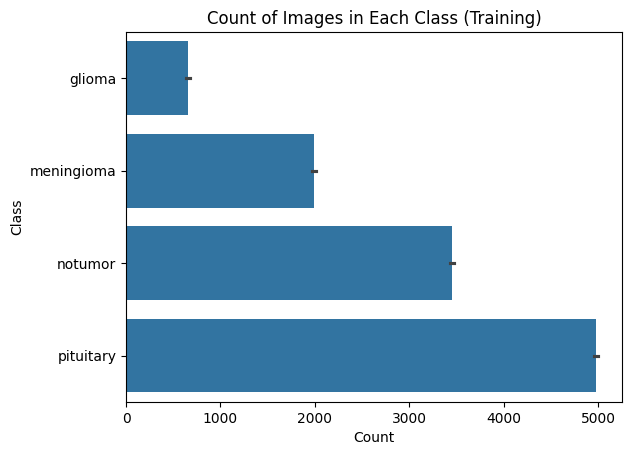

In [7]:
# Count of images in training dataset
plt.figure()
sns.barplot(tr_df["Class"])
plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Count of Images in Each Class (Training)")
plt.show()

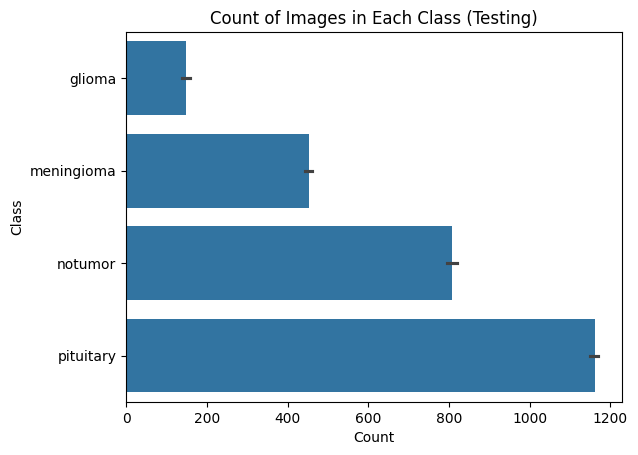

In [8]:
# Count of images in the training daaset
plt.figure()
sns.barplot(ts_df["Class"])
plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Count of Images in Each Class (Testing)")
plt.show()

In [9]:
batch_size = 32
img_size = (299,299)

_gen = ImageDataGenerator(rescale=1/255)

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = _gen.flow_from_dataframe(tr_df, x_col="Class Path", 
                                  y_col="Class",
                                  batch_size=batch_size, 
                                  target_size=img_size,)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col="Class Path",
                                    y_col="Class", 
                                    batch_size=16, 
                                    target_size=img_size, 
                                    shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [10]:
# Use annomoly detection, the notumor images to the tumor images. Could tell us where the tumor is.

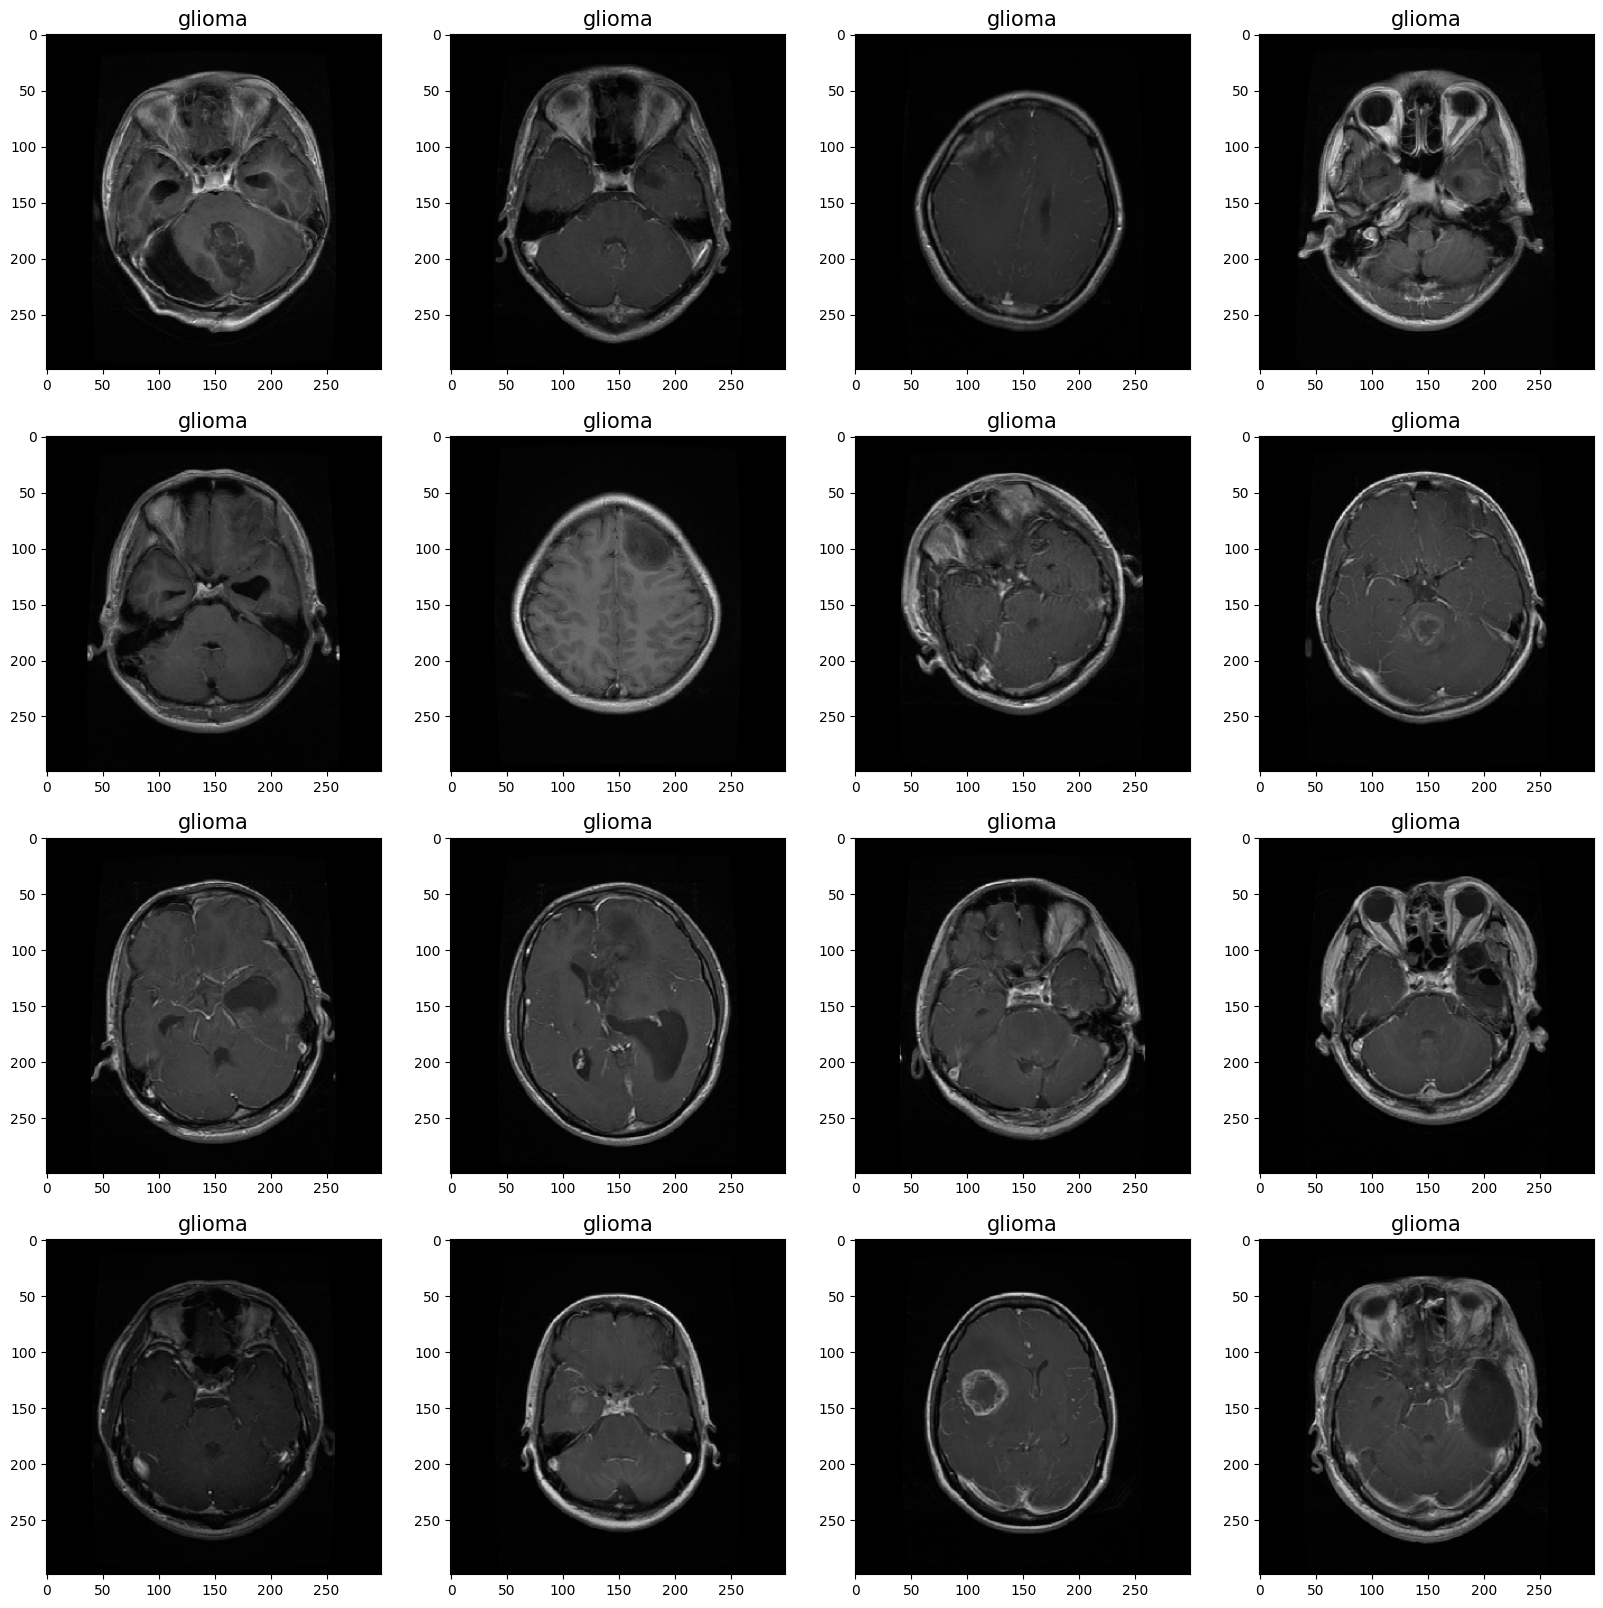

In [11]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20,20))
for i, (image,label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i+1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color="k", fontsize=15)
plt.show()

class_dict = tr_gen.class_indices
classes = list(class_dict.keys())

images = []
labels = []

for i in range(3):
    batch_images, batch_labels = next(ts_gen)
    images.extend(batch_images)
    labels.extend(batch_labels)

images = np.array(images)
labels = np.array(labels)

plt.figure(figsize=(20,20))
for i, (image,label) in enumerate(zip(images, labels)):
    if i >= 40: break 
    plt.subplot(4,4, i+1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color="k", fontsize=15)
plt.show()

#### Initial CNN

In [12]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(299,299,3)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(tr_gen, epochs=5, batch_size=64)
test_loss, test_acc = model.evaluate(ts_gen, verbose=2)
print("Loss:", test_loss)
print("Accuracy:", test_acc)

C:\Users\steph\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\steph\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.7089 - loss: 1.5040
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 137s 763ms/step - accuracy: 0.9235 - loss: 0.2089
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 137s 763ms/step - accuracy: 0.9757 - loss: 0.0766
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 137s 762ms/step - accuracy: 0.9930 - loss: 0.0268
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 139s 775ms/step - accuracy: 0.9986 - loss: 0.0093
82/82 - 38s - 465ms/step - accuracy: 0.9443 - loss: 0.1826
Loss: 0.1826464831829071
Accuracy: 0.9443173408508301


82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step


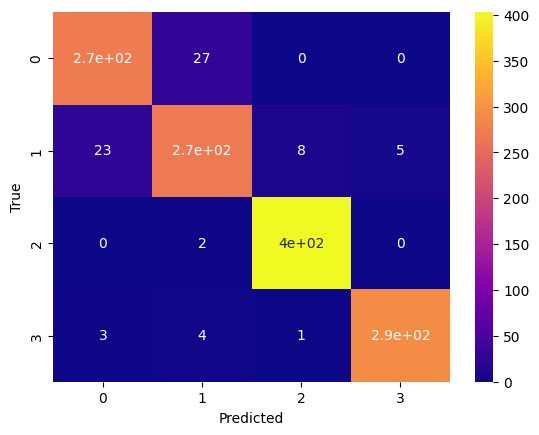

              precision    recall  f1-score   support

      glioma       0.91      0.91      0.91       300
  meningioma       0.89      0.88      0.89       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.98      0.97      0.98       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



In [13]:
y_pred = np.argmax(model.predict(ts_gen), axis=-1)
y_true = ts_gen.classes
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap="plasma")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=classes))